## Inference multiple step 
- Original version of model is only predict 1 day with Previous [seq_length] days
- Use first input data from real data. 
- Make next input data = ( concat(prev input data + prev predicted value))[1:] 
- Iterate during the length of label value

#### Results
- Really Bad performance

In [86]:
from determined.experimental import client

experiment_id = 262

chk = client.get_experiment(experiment_id).list_checkpoints(sort_by="Mean Absolute Percentage Error",order_by=client.OrderBy.ASC,max_results=1)

In [87]:
print(chk)

[Checkpoint(uuid=51281567-d7d6-43ca-bfd5-ecc629508bd8, task_id=262.a56d0ede-ca0a-4acb-9154-406057020bf0, trial_id=529)]


In [88]:
path = chk[0].download()

print(path)

!ls -al checkpoints/51281567-d7d6-43ca-bfd5-ecc629508bd8

checkpoints/51281567-d7d6-43ca-bfd5-ecc629508bd8
total 180
drwxr-xr-x 2 root root     61 Nov  7 07:59 .
drwxr-xr-x 3 root root     50 Nov  7 07:59 ..
-rw-rw-rw- 1 root root 174690 Jan  1  1970 checkpoint.pt
-rw-rw-rw- 1 root root    105 Jan  1  1970 metadata.json
-rw-rw-rw- 1 root root      7 Jan  1  1970 state


In [89]:
trial = client.get_trial(529)
hparams = trial.hparams
print(hparams)

{'batch_size': 32, 'dim_feedforward': 10, 'lr': 0.0001, 'num_heads': 2, 'num_layers': 2, 'seq_length': 8}


In [90]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # self.register_buffer('pe', pe)
        self.register_parameter('pe', nn.Parameter(pe, requires_grad=False))

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TransformerModel(nn.Module): # inherts from nn.Modeul which is a base class of PyTorch with useful methods and attributes
    def __init__(self, hparams):
        super(TransformerModel, self).__init__() # calling the constructor (def __init__) of nn.Module
        input_dim = 1
        seq_length = hparams["seq_length"]
        num_layers = hparams["num_layers"]
        num_heads = hparams["num_heads"]
        dim_feedforward = hparams["dim_feedforward"]
        output_dim = 1
        self.embedding = nn.Linear(input_dim, seq_length) # use linear layer as an embedding layer.
        transformer_layer = nn.TransformerEncoderLayer(d_model=seq_length, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(seq_length, output_dim)
        self.pos_encoder = PositionalEncoding(seq_length)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        src = src.permute(1, 0, 2)  # Reshape for transformer. Reshape input tensor to fit requirements of transformer encoder, which is this format (sequence length, batch size, features)
        output = self.transformer(src)
        output = output.permute(1, 0, 2)  # Reshape back
        output = self.fc_out(output) # [batch, seq, seq] -> [batch, seq, 1]
        return output[:,-1,:] 

device = torch.device("cuda")
model = TransformerModel(hparams).to(device)

chk_file = path + "/checkpoint.pt"
loaded_state = torch.load(chk_file)

for key in loaded_state.copy().keys():
    # print(key)
    if 'module.' in key:
        loaded_state[key.replace('module.','')] = loaded_state[key]
        del loaded_state[key]

model.load_state_dict(loaded_state) #,strict=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:292: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [91]:
# !pip install yfinance

In [92]:
model.eval()

import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


def create_sequences_offline(symbol,start,end, seq_length, is_offline,is_train):
  if is_offline:
    if is_train:
      file_name = f'input/train_{symbol}_{start}_{end}.csv'
    else:
      file_name = f'input/test_{symbol}_{start}_{end}.csv'
    print(f"Read input data from {file_name} file!")
    data = pd.read_csv(file_name,header=[0,1],index_col=0)
  else:
    data = yf.download(symbol, start=start, end=end)

  prices = data['Close'].values.reshape(-1, 1)
  scaler = MinMaxScaler(feature_range=(-1, 1)) # diff
  prices_normalized = scaler.fit_transform(prices)
  prices_tensor = torch.FloatTensor(prices_normalized)
  
  xs,ys = [],[]
  for i in range(len(prices_tensor)-seq_length-1):
    x = prices_tensor[i:(i+seq_length)] # use prices_tensor[0:5] to predict data[5], use data[1:6] to predict data[6]
    y=prices_tensor[i+seq_length]
    xs.append(x)
    ys.append(y)
  return torch.stack(xs), torch.stack(ys), scaler

def predict(model, input_data, device):
    input_data = input_data.to(device)
    # print(input_data)
    model.eval()  # Switch the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        prediction = model(input_data)  # Get the model's prediction

    return prediction

def eval_with_dataset(model, scaler,X,y,device,is_finished,symbol):
    model.eval() # Prepare the model for evaluation

    all_predictions = []
    all_actuals = []
    
    input = X[0] # initial input 
    print(input)
    with torch.no_grad():
        for i in range(len(y)):
        # for i in range(8):
            # single_prediction = predict(model, X[i].unsqueeze(0),device)
            single_prediction = predict(model, input.unsqueeze(0),device)
            single_prediction = single_prediction.cpu()
            predicted_value = single_prediction.item()  # Extract the last element
            all_predictions.append(predicted_value)
            all_actuals.append(y[i].item())
            input = torch.cat([input,torch.tensor([[predicted_value]])],dim=0)[1:]
            # print(input)
            # print(torch.tensor([[predicted_value]]).shape)
            # raise
    # raise
    
    # Convert predictions and actuals to the original scale
    all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))[1:]
    all_actuals = scaler.inverse_transform(np.array(all_actuals).reshape(-1, 1))[:-1]

    # Calculate MSE and MAE
    mse = mean_squared_error(all_actuals, all_predictions).item()
    mae = mean_absolute_error(all_actuals, all_predictions).item()
    mape = mean_absolute_percentage_error(all_actuals, all_predictions).item()

    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Absolute Percentage Error: {mape}')

    all_actuals_list = all_actuals.reshape(1,-1).squeeze().tolist()
    all_predictions_list = all_predictions.reshape(1,-1).squeeze().tolist()

    plt.figure(figsize=(12, 6))
    plt.plot(all_actuals, label='Actual Prices', color='blue')
    plt.plot(all_predictions, label='Predicted Prices', color='red')
    plt.title(f'{symbol} Actual vs Predicted Stock Prices')
    plt.xlabel('Time (Days)')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
    # return mse, mae, mape
    return all_actuals_list, all_predictions_list

In [93]:
symbol = 'AAPL' #'^GSPC'
start_test = '2024-01-01'
end_test = '2024-08-31'
seq_length = 8
X_test, y_test, scaler_test = create_sequences_offline(symbol,start_test,end_test, seq_length,is_offline=False,is_train=False)

[*********************100%***********************]  1 of 1 completed


tensor([[-0.4088],
        [-0.4486],
        [-0.5156],
        [-0.5365],
        [-0.4111],
        [-0.4231],
        [-0.3930],
        [-0.4102]])
Mean Squared Error: 964.3355118648029
Mean Absolute Error: 22.747983138963015
Mean Absolute Percentage Error: 0.10778826782995699


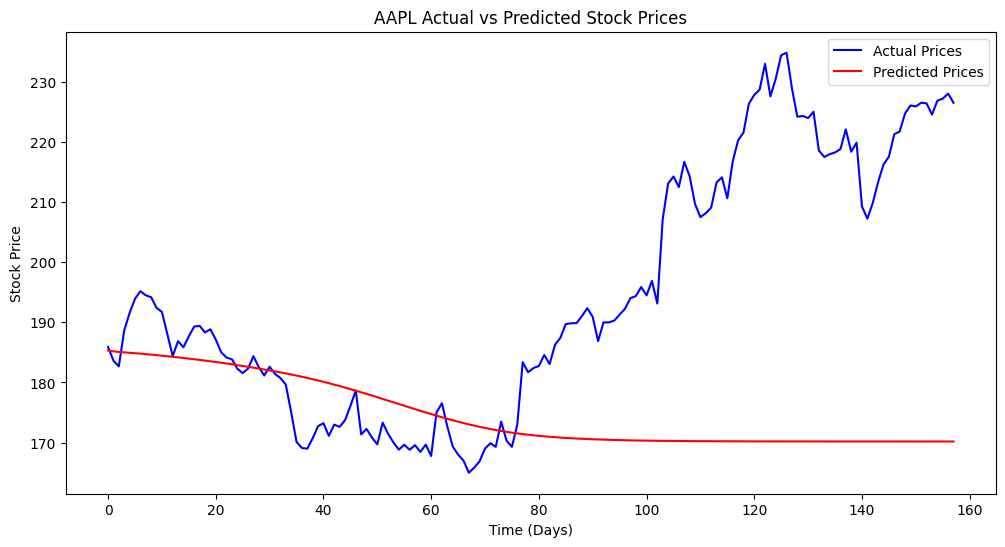

In [94]:
act,pred = eval_with_dataset(model,scaler_test,X_test,y_test,device,True,symbol) # eval with new data